In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium 
import requests
import json
from geopy.distance import geodesic

hdb_resale_prices = pd.read_csv("final_hdb_resale_prices.csv")

<h3>Data Preparation</h3>

In [3]:
# drop the first column of hdb resale prices database
hdb_resale_prices.drop(columns=hdb_resale_prices.columns[0], inplace=True)
hdb_resale_prices.head()

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,resale_price,Latitude,Longitude,cpi_multiplier,...,year,no.of bto,resale application,demand ratio,remaining_lease_months,address,Distance to nearest MRT,Distance to CBD,Distance to nearest mall,isMatureEstate
0,2017-01,ANG MO KIO,3 ROOM,2,67.0,New Generation,250000.0,1.370943,103.837975,1.02372,...,2017,14464,20894.0,1.02,727,108 ANG MO KIO AVE 4,166.825954,9696.234644,896.944633,1
1,2017-01,ANG MO KIO,3 ROOM,2,67.0,New Generation,262000.0,1.380709,103.835368,1.02372,...,2017,14464,20894.0,1.02,749,602 ANG MO KIO AVE 5,532.155055,10808.143550,1527.724531,1
2,2017-01,ANG MO KIO,3 ROOM,5,68.0,New Generation,265000.0,1.366201,103.857201,1.02372,...,2017,14464,20894.0,1.02,744,465 ANG MO KIO AVE 10,945.375055,9087.920590,880.143181,1
3,2017-01,ANG MO KIO,3 ROOM,2,67.0,New Generation,265000.0,1.381041,103.835132,1.02372,...,2017,14464,20894.0,1.02,749,601 ANG MO KIO AVE 5,498.419646,10848.697720,1571.446900,1
4,2017-01,ANG MO KIO,3 ROOM,2,68.0,New Generation,275000.0,1.376807,103.842018,1.02372,...,2017,14464,20894.0,1.02,756,150 ANG MO KIO AVE 5,636.982785,10284.079570,695.573226,1


<h5><b>Checking for Missing Values</b></h5>

There are no missing values in the dataset.

In [4]:
hdb_resale_prices.isnull().sum()

month                          0
town                           0
flat_type                      0
storey_range                   0
floor_area_sqm                 0
flat_model                     0
resale_price                   0
Latitude                       0
Longitude                      0
cpi_multiplier                 0
cpi_adjusted_price             0
year                           0
no.of bto                      0
resale application          2150
demand ratio                2150
remaining_lease_months         0
address                        0
Distance to nearest MRT        0
Distance to CBD                0
Distance to nearest mall       0
isMatureEstate                 0
dtype: int64

<h5><b>Reason for Null Values for Resale Application and Demand Ratio</b></h5>

As shown below, the 2150 number of null values for 'resale application' and 'demand ratio' is due to the lack of data for those columns in 2023. There is no data available for the demand for resale flats in 2023. Hence, the resale application and demand ratio is null for 2023.

In [5]:
hdb_resale_prices.groupby('year').count().loc[2023]

month                       2150
town                        2150
flat_type                   2150
storey_range                2150
floor_area_sqm              2150
flat_model                  2150
resale_price                2150
Latitude                    2150
Longitude                   2150
cpi_multiplier              2150
cpi_adjusted_price          2150
no.of bto                   2150
resale application             0
demand ratio                   0
remaining_lease_months      2150
address                     2150
Distance to nearest MRT     2150
Distance to CBD             2150
Distance to nearest mall    2150
isMatureEstate              2150
Name: 2023, dtype: int64

In [6]:
hdb_resale_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143259 entries, 0 to 143258
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   month                     143259 non-null  object 
 1   town                      143259 non-null  object 
 2   flat_type                 143259 non-null  object 
 3   storey_range              143259 non-null  int64  
 4   floor_area_sqm            143259 non-null  float64
 5   flat_model                143259 non-null  object 
 6   resale_price              143259 non-null  float64
 7   Latitude                  143259 non-null  float64
 8   Longitude                 143259 non-null  float64
 9   cpi_multiplier            143259 non-null  float64
 10  cpi_adjusted_price        143259 non-null  float64
 11  year                      143259 non-null  int64  
 12  no.of bto                 143259 non-null  int64  
 13  resale application        141109 non-null  f

In [7]:
hdb_resale_prices.describe()

,storey_range,floor_area_sqm,resale_price,Latitude,Longitude,cpi_multiplier,cpi_adjusted_price,year,no.of bto,resale application,demand ratio,remaining_lease_months,Distance to nearest MRT,Distance to CBD,Distance to nearest mall,isMatureEstate
count,143259.000000,143259.000000,1.432590e+05,143259.000000,143259.000000,143259.000000,1.432590e+05,143259.000000,143259.000000,141109.000000,141109.000000,143259.000000,143259.000000,143259.000000,143259.000000,143259.000000
mean,8.752832,98.426986,4.811102e+05,1.367615,103.842061,1.019295,4.912411e+05,2019.738718,14391.102604,25448.035979,1.053241,896.769055,826.874082,12299.141465,655.701838,0.395082
std,5.953163,23.302954,1.639293e+05,0.042605,0.071205,0.023700,1.705097e+05,1.737609,4090.397156,3114.704168,0.086825,162.275193,465.428696,4402.699264,372.201682,0.488870
min,2.000000,51.000000,1.400000e+05,1.270380,103.644248,0.997140,1.395996e+05,2017.000000,7314.000000,20894.000000,0.910000,516.000000,31.759538,527.673362,0.000708,0.000000
25%,5.000000,84.000000,3.600000e+05,1.337020,103.781869,1.000000,3.671007e+05,2018.000000,12114.000000,22005.000000,1.020000,766.000000,469.755281,9580.092801,381.821475,0.000000
50%,8.000000,95.000000,4.500000e+05,1.367769,103.847231,1.011000,4.575458e+05,2020.000000,13756.000000,26436.000000,1.120000,897.000000,739.025050,13226.217950,586.159628,0.000000
75%,11.000000,113.000000,5.680000e+05,1.395853,103.899752,1.023720,5.831693e+05,2021.000000,17556.000000,26436.000000,1.130000,1030.000000,1100.184249,15325.212600,863.626024,1.000000
max,50.000000,249.000000,1.418000e+06,1.457071,103.987463,1.064060,1.508837e+06,2023.000000,20064.000000,30370.000000,1.140000,1173.000000,3646.118783,23064.390350,3999.391261,1.000000


<h1>Exploratory Data Analysis</h1>

array([[<AxesSubplot:title={'center':'storey_range'}>,
        <AxesSubplot:title={'center':'floor_area_sqm'}>,
        <AxesSubplot:title={'center':'cpi_adjusted_price'}>],
       [<AxesSubplot:title={'center':'no.of bto'}>,
        <AxesSubplot:title={'center':'resale application'}>,
        <AxesSubplot:title={'center':'demand ratio'}>],
       [<AxesSubplot:title={'center':'remaining_lease_months'}>,
        <AxesSubplot:title={'center':'Distance to nearest MRT'}>,
        <AxesSubplot:title={'center':'Distance to CBD'}>],
       [<AxesSubplot:title={'center':'Distance to nearest mall'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

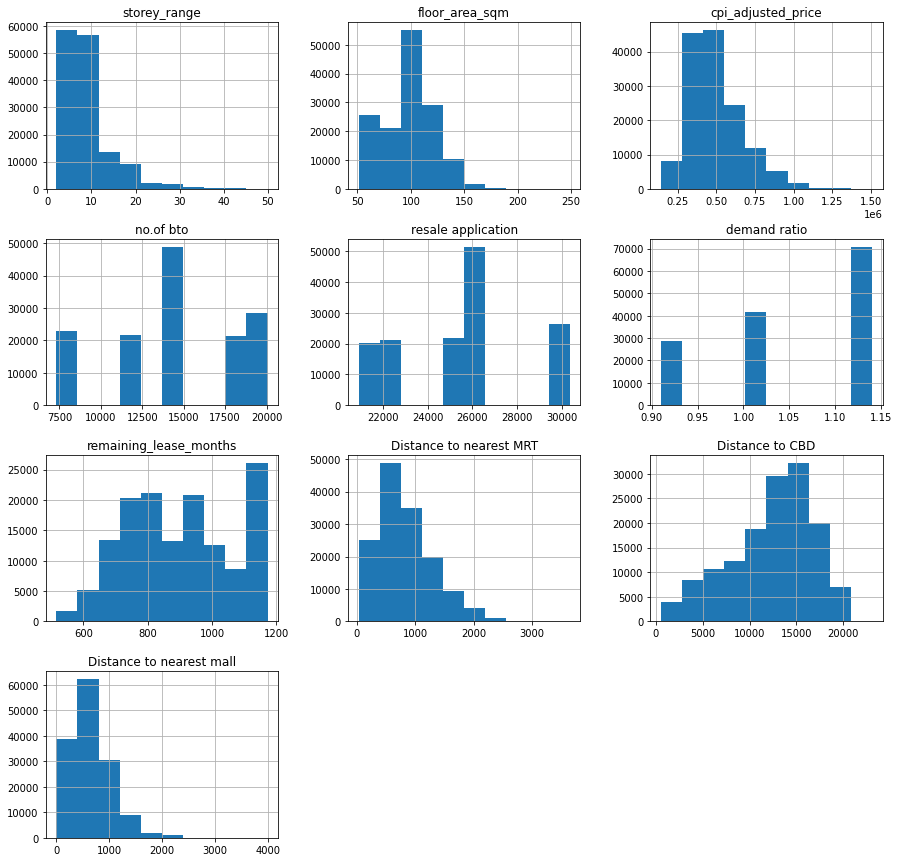

In [13]:
numerical = hdb_resale_prices[["storey_range", "floor_area_sqm", "cpi_adjusted_price", "no.of bto", "resale application", "demand ratio", "remaining_lease_months", "Distance to nearest MRT", "Distance to CBD", "Distance to nearest mall"]]
numerical.hist(figsize=(15,15))

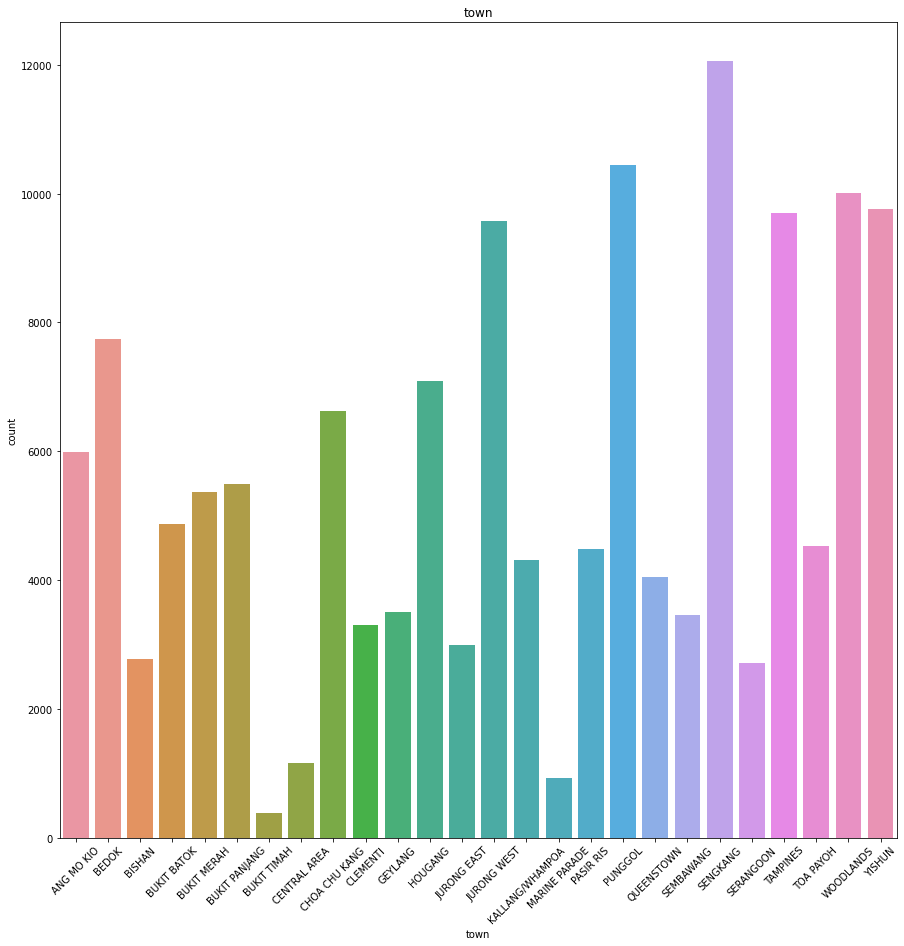

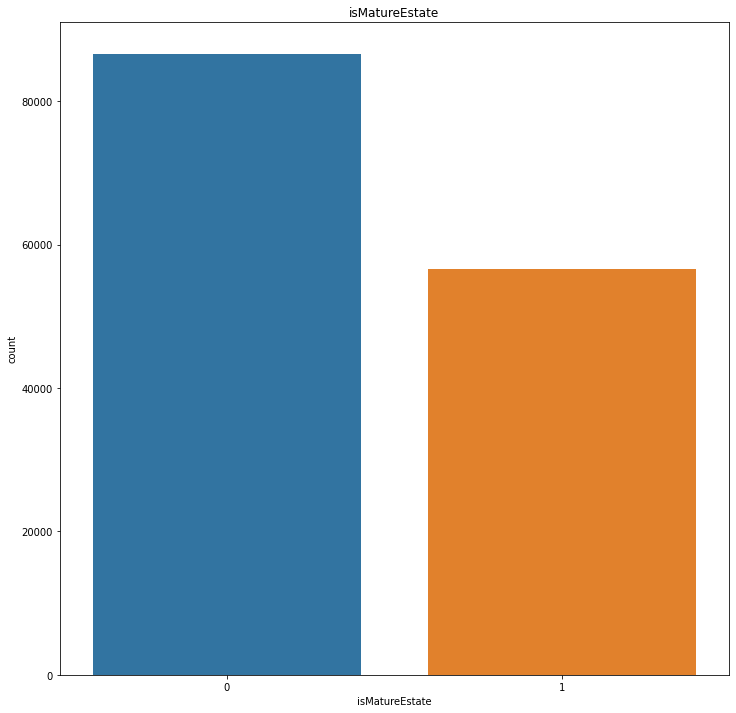

In [25]:
fig, ax = plt.subplots(figsize=(15,15))
sns.countplot(data=hdb_resale_prices, x="town", ax=ax)
ax.set_title("town")
plt.xticks(rotation=45)
plt.show()

fig, ax = plt.subplots(figsize=(12,12))
sns.countplot(data=hdb_resale_prices, x="isMatureEstate", ax=ax)
ax.set_title("isMatureEstate")
plt.show()

In [ ]:
hdb_resale_prices.hist(figsize=(20,20))

### Distribution of Resale Prices
<h5><b>Use mean or median resale price?</b></h5>

As seen in the plotted histogram for the resale prices from 2017 to 2023, the resale price data is right skewed. Since the price data does not follow a symmetric distribution, we will use the <i><b>median price</b></i> instead of the mean price to represent the average resale price of the flats.

The right-skewed KDE plot also suggests that the mean prices are greater than the median.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x=hdb_resale_prices['resale_price'])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Distribution of Resale Prices")

sns.histplot(data=hdb_resale_prices, x="resale_price", ax=ax, kde=True)

<h3>Number of Resale Flats Sold Across the Years</h3>


In [ ]:
df_years = hdb_resale_prices.groupby('year').count()
df_years

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Number of Resale Flats per Year")
ax.set_ylabel("Count")

# plot the data as a line plot
sns.lineplot(x="year", y="month", data=df_years, color="purple", ax=ax)

# label points on the plot
for x, y in zip(df_years.index, df_years["month"]):
   # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
   plt.text(x = x, y = y-150, # y-coordinate position of data label, adjusted to be 150 below the data point
   s = "{:.0f}".format(y), # data label, formatted to ignore decimals
   color = "purple") # set colour of line

plt.show()

In [ ]:
# plot sale of flats across the years
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Number of Resale Flats per Year by Flat Type")

shared_plot = sns.countplot(x="year", hue="flat_type", data=hdb_resale_prices)

plt.show()

<h3>Flat Type Distribution</h3>

Based on the plotted bar chart, the majority of the resale flats are 4-room flats and multi-generation flats account for the least number of resale flats.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(x=hdb_resale_prices['flat_type'], data=hdb_resale_prices)
abs_values = hdb_resale_prices['flat_type'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Number of Resale Flats by Flat Type')
plt.show()

### Resale Price per Year by Flat Type

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Resale Price per Year by Flat Type")
ax.set_ylabel("Resale Price")

# plot the data as a line plot
sns.lineplot(x="year", y="resale_price", data=hdb_resale_prices, hue="flat_type")


plt.show()

### Distribution of Resale Price by Flat Type

In [ ]:
# plot distribution of prices against flat type 
fig, ax = plt.subplots(figsize=(15, 15))

# plot boxplot
boxplot = sns.boxplot(x=hdb_resale_prices['flat_type'], y=hdb_resale_prices['resale_price'], data=pd.melt(hdb_resale_prices), order=["3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE"])

# plot stripplot on top of boxplot
boxplot = sns.stripplot(x=hdb_resale_prices['flat_type'], y=hdb_resale_prices['resale_price'], data=pd.melt(hdb_resale_prices), marker="o", alpha=0.25, color="black", order=["3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE"])

# set title and labels
boxplot.axes.set_title("Distribution of Resale Price by Flat Type")
boxplot.set_xlabel("Flat Type", fontsize=14)
boxplot.set_ylabel("Resale Price", fontsize=14)

# display median values for each flat type
medians = hdb_resale_prices.groupby(['flat_type'])['resale_price'].median()
# attach median values to boxplot
vertical_offset = hdb_resale_prices['resale_price'].median() * 0.05 # offset from median for display

for xtick in boxplot.get_xticks():
   boxplot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], horizontalalignment='center',color='w',weight='semibold')

plt.show()

### Identifying Outliers

Based on observations of the plotted box plot and strip plot, there seems to be some outliers in 3-room and 4-room flats. To identify the outliers, we will use the <i><b>Interquartile Range (IQR)</b></i> method.

In [ ]:
df_3room = hdb_resale_prices[hdb_resale_prices['flat_type'] == '3 ROOM']

Q1 = df_3room['resale_price'].quantile(0.25)
Q3 = df_3room['resale_price'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

# get low outlier(s)
low_3room = df_3room[df_3room['resale_price'] < Q1 - 1.5 * IQR]

# get high outlier(s)
high_3room = df_3room[df_3room['resale_price'] > Q3 + 1.5 * IQR]

### Investigating Low 3 Room Resale Outliers

Below shows the outlier 3 room resale flat that has an unusually low resale prie of $140,000, located at Toa Payoh East. Compared to the mean resale price of 3 room flats, the price of this resale flat is 41.97% lower as based on calculations.

In [ ]:
low_3room

In [ ]:
percentage_diff = 100 - round((df_3room['resale_price'].mean() - low_3room.iloc[0]['resale_price'])/df_3room['resale_price'].mean() * 100, 2)

print('Price of low outlier 3 room flat is ' + str(percentage_diff) + "% lower than the mean price of 3 room flats.")

### Investigating High 3 Room Resale Outliers

To identify the 7 3-room outliers that are above $1,000,000, we sorted the 3-room resale flats by price in descending order to derive the top 7 records. We observed that all these are located in the Kallang/Whampoa area which is located relatively close to the Central Business District (CBD) of Singapore. Furthermore, they are more premium flat models with a higher floor area. Hence, it is not surprising that these 3-room flats are priced higher than the average 3-room resale flat.

In [ ]:
# print shape of high_3room
print(high_3room.shape)

high_3room.sort_values(by='resale_price', ascending=False).head(7)

### 4 Room Flat Outliers

We investigated the 4-room resale flats that have been sold at an unusually high price. Based on the records below, they are located in the central area and relatively close to the CBD and MRT stations like Tanjong Pagar and Outram Park. 

In [ ]:
df_4room = hdb_resale_prices[hdb_resale_prices['flat_type'] == '4 ROOM']

Q1 = df_4room['resale_price'].quantile(0.25)
Q3 = df_4room['resale_price'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

# get high outlier(s)
high_4room = df_4room[df_4room['resale_price'] > Q3 + 1.5 * IQR]

# get top 10 highest 4 room resale records
high_4room.sort_values(by='resale_price', ascending=False).head(10)

### Investigating the distribution of flat_model

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(y='flat_model', data=hdb_resale_prices)
abs_values = hdb_resale_prices['flat_model'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title('Number of Resale Flats by Flat Model')
plt.show()

### Demand for resale


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(x=hdb_resale_prices['year'], data=hdb_resale_prices)
abs_values = hdb_resale_prices['year'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Number of Resale Applications Per Year')
plt.show()

### Correlation

In [ ]:
plt.figure(figsize=(16, 6))
corr_df = hdb_resale_prices.corr()
hm = sns.heatmap(corr_df, annot=True)

### Investigate if lease is an important factor

In [ ]:
import csv
hdb_resale_listings = []

with open('final_hdb_resale_prices.csv', newline='', encoding="utf8") as f:
    reader = csv.reader(f)
    for row in reader:
        hdb_resale_listings.append(row)

    # Remove header
    hdb_resale_listings_headers = hdb_resale_listings[0]
    hdb_resale_listings = hdb_resale_listings[1:]
    
print(hdb_resale_listings[0]) # Print first row of data

In [ ]:
average_resale_for_lease_year_remaining = {}
for data in hdb_resale_listings:
    if round(float(data[16])/12) not in average_resale_for_lease_year_remaining:
        average_resale_for_lease_year_remaining[round(float(data[16])/12)] = []
        average_resale_for_lease_year_remaining[round(float(data[16])/12)].append(float(data[7]))
    else:
        average_resale_for_lease_year_remaining[round(float(data[16])/12)].append(float(data[7]))
    

In [ ]:
for item in average_resale_for_lease_year_remaining:
    avg = round(sum(average_resale_for_lease_year_remaining[item])/len(average_resale_for_lease_year_remaining[item]))
    average_resale_for_lease_year_remaining[item] = avg

In [ ]:
lease = list(average_resale_for_lease_year_remaining.keys())
average_resale_value = list(average_resale_for_lease_year_remaining.values())

## Write your code below
fig,ax = plt.subplots(figsize=(18,12))
ax.plot(lease,average_resale_value,marker='d')
ax.set_ylabel('Resale Value')
ax.set_xlabel('Lease Remaining')
ax.set_title('Average Resale Value for Lease Years Remaining')
plt.show()


### Investigate how floor area correlate with price

In [ ]:
floor_area_sqm = []
resale_price = []
for data in hdb_resale_listings:
    floor_area_sqm.append(float(data[5]))
    resale_price.append(float(data[7]))
fig,ax = plt.subplots(figsize=(18,12))
ax.scatter(floor_area_sqm,resale_price)
ax.set_xlabel('Floor Area (in square metres)')
ax.set_ylabel('Sale Price (in million SGD)')
ax.set_title('Relationship between Floor Area and Resale Price')
plt.show()


### Investigating resale counts by town

In [ ]:
resale_counts_by_town = {}  # Populate this dictionary with counts

import operator
## Write your code below

for data in hdb_resale_listings:
    hdb_town = data[2]
    
    if hdb_town in resale_counts_by_town:
        
        resale_counts_by_town[hdb_town] += 1 
    
    else:
        
        resale_counts_by_town[hdb_town] = 1

    
        
sorted_resale_counts_by_town = dict(sorted(resale_counts_by_town.items(), key=operator.itemgetter(1),reverse=True))

In [ ]:
resale_counts_sorted_desc = sorted_resale_counts_by_town
neighbourhood_listings = list(resale_counts_sorted_desc.keys())
num_listings = list(resale_counts_sorted_desc.values())
# Import matplotlib library here

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(18,12))
ax.bar(neighbourhood_listings,num_listings)
ax.set_title('Counts of Resale Flats from Jan 2017 to June 2020')
ax.set_xticklabels(neighbourhood_listings,rotation = 90)
ax.set_ylabel('Number of Resale Flats')
ax.set_xlabel('Town')
plt.show()

# Folium Clusters

<h3>3 Room</h3>

In [ ]:
import folium
from folium.plugins import HeatMap
lat_long = []
## Write your code below
for data in hdb_resale_listings:
    if data[3] == '3 ROOM':
        lat_long.append([data[8],data[9]])
map_folium = folium.Map(location=[1.357,103.826], height=350, width=800,zoom_start=11.4)

HeatMap(lat_long, radius=8, gradient={0.2:'blue', 0.4:'purple', 0.6:'orange', 1.0:'red'}).add_to(map_folium) 

display(map_folium)

In [ ]:
from folium.plugins import MarkerCluster   
## Write your code below (Note: the Folium map output might take a while to load)
map_folium = folium.Map(location=[1.357,103.826], height=550, width=900, zoom_start=11.5)

marker_cluster = MarkerCluster().add_to(map_folium)
for data in hdb_resale_listings:
    if data[3] == '3 ROOM':
        lat_long_listing = [data[8],data[9]]
        pop_display_price = '$' + str(data[6])
        tooltipmsg = 'Click to view price'

        folium.Marker(lat_long_listing,popup=pop_display_price,tooltip = tooltipmsg).add_to(marker_cluster)

display(map_folium)


<h3>4 Room</h3>

In [ ]:
import folium
from folium.plugins import HeatMap
lat_long = []
## Write your code below
for data in hdb_resale_listings:
    if data[3] == '4 ROOM':
        lat_long.append([data[8],data[9]])
map_folium = folium.Map(location=[1.357,103.826], height=350, width=800,zoom_start=11.4)

HeatMap(lat_long, radius=8, gradient={0.2:'blue', 0.4:'purple', 0.6:'orange', 1.0:'red'}).add_to(map_folium) 

display(map_folium)



In [ ]:
from folium.plugins import MarkerCluster   
## Write your code below (Note: the Folium map output might take a while to load)
map_folium = folium.Map(location=[1.357,103.826], height=550, width=900, zoom_start=11.5)

marker_cluster = MarkerCluster().add_to(map_folium)
for data in hdb_resale_listings:
    if data[3] == '4 ROOM':
        lat_long_listing = [data[8],data[9]]
        pop_display_price = '$' + str(data[6])
        tooltipmsg = 'Click to view price'

        folium.Marker(lat_long_listing,popup=pop_display_price,tooltip = tooltipmsg).add_to(marker_cluster)

display(map_folium)


<h3>5 Room</h3>

In [ ]:
import folium
from folium.plugins import HeatMap
lat_long = []
## Write your code below
for data in hdb_resale_listings:
    if data[3] == '5 ROOM':
        lat_long.append([data[8],data[9]])
map_folium = folium.Map(location=[1.357,103.826], height=350, width=800,zoom_start=11.4)

HeatMap(lat_long, radius=8, gradient={0.2:'blue', 0.4:'purple', 0.6:'orange', 1.0:'red'}).add_to(map_folium) 

display(map_folium)

In [ ]:
from folium.plugins import MarkerCluster   
## Write your code below (Note: the Folium map output might take a while to load)
map_folium = folium.Map(location=[1.357,103.826], height=550, width=900, zoom_start=11.5)

marker_cluster = MarkerCluster().add_to(map_folium)
for data in hdb_resale_listings:
    if data[3] == '5 ROOM':
        lat_long_listing = [data[8],data[9]]
        pop_display_price = '$' + str(data[6])
        tooltipmsg = 'Click to view price'

        folium.Marker(lat_long_listing,popup=pop_display_price,tooltip = tooltipmsg).add_to(marker_cluster)

display(map_folium)

<h3>Executive</h3>

In [ ]:
import folium
from folium.plugins import HeatMap
lat_long = []
## Write your code below
for data in hdb_resale_listings:
    if data[3] == 'EXECUTIVE':
        lat_long.append([data[8],data[9]])
map_folium = folium.Map(location=[1.357,103.826], height=350, width=800,zoom_start=11.4)

HeatMap(lat_long, radius=8, gradient={0.2:'blue', 0.4:'purple', 0.6:'orange', 1.0:'red'}).add_to(map_folium) 

display(map_folium)

In [ ]:
from folium.plugins import MarkerCluster   
## Write your code below (Note: the Folium map output might take a while to load)
map_folium = folium.Map(location=[1.357,103.826], height=550, width=900, zoom_start=11.5)

marker_cluster = MarkerCluster().add_to(map_folium)
for data in hdb_resale_listings:
    if data[3] == 'EXECUTIVE':
        lat_long_listing = [data[8],data[9]]
        pop_display_price = '$' + str(data[6])
        tooltipmsg = 'Click to view price'

        folium.Marker(lat_long_listing,popup=pop_display_price,tooltip = tooltipmsg).add_to(marker_cluster)

display(map_folium)

# Feature Engineering

Based on the studies and analysis performed by other researchers, the following features that have been concluded to be <b>important</b> in determining the prices of HDB resale flats are as follows: 
- Time Taken to Travel to Central Business District (CBD), Raffles Place
- Number of Years Left on Lease
- Maturity of Estate
<br>

We are also considering <b>other factors</b> that have not been explored by other reseearchers. The factors that we have identified are as follows: 
- Singapore's Inflation Rate
- Flat Model
- Floor Level
- Prices of BTO
- Number of BTO Flats Launched that Year
- Demand Ratio in Resale Flat


Before adding these features into our dataset, we will first perform some data cleaning and feature engineering on the existing features in our dataset.

- convert the flat condition with quantitative measures
- combine the resale prices and the sqm to find the $/sqm (still need to keep sqm to quantify the size!!) 
- remaining lease should be converted to a ratio 
- combine the block and street name to obtain the lat,long - from there we can obtain the distance from amentities, distance from public transport, distance from central
- using the town --- can also do some quantitative measures to quantify how mature the estate is
- average price of the houses of the same category in the area from here we derive the estimated COV
- demand-scarcity ratio --- not sure how to quantify this
- total sale price of the hdb
- there should be a way to convert the storey range to scoring value


<b>DISCLAIMER: </b> Some of the feature engineering code can be found in resale_data_processing.ipynb. They have been shifted there for ease of reading and efficiency purposes.

### Filtering Out Flats That Have Fewer Than 3 Rooms 

Since the young are more likely to purchase 3,4,5 room and executive flats we decided to drop the records of 1 room, 2room and multi-gen flats.

In [ ]:
# drop 1room, 2room, and multi-generation flats
hdb_resale_prices = hdb_resale_prices[hdb_resale_prices['flat_type'] != '1 ROOM']
hdb_resale_prices = hdb_resale_prices[hdb_resale_prices['flat_type'] != '2 ROOM']
hdb_resale_prices = hdb_resale_prices[hdb_resale_prices['flat_type'] != 'MULTI-GENERATION']

hdb_resale_prices.reset_index(inplace=True)

In [ ]:
hdb_resale_prices.head()

In [ ]:
#add year column to dataframe
hdb_resale_prices['year'] = pd.DatetimeIndex(hdb_resale_prices['month']).year

### Calculating Price Per Square Meter

In [ ]:
# add new column to store adjusted resale price 
hdb_resale_prices['cpi_adjusted_price_per_sqm'] = hdb_resale_prices["cpi_adjusted_price"] / hdb_resale_prices["floor_area_sqm"]
hdb_resale_prices.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=hdb_resale_prices, x="cpi_adjusted_price_per_sqm", ax=ax)



<h3>IsMature Estate</h3>

In [ ]:
# list_mature_estates = ["ang mo kio", 
#                         "bishan", 
#                         "clementi",
#                         "bukit merah",
#                         "bedok",
#                         "bukit timah",
#                         "geylang",
#                         "central",
#                         "marine parade",
#                         "queenstown",
#                         "pasir ris",
#                         "kallang" , "whampoa", "marine parade" , "serangoon", "tampines", "toa payoh"]

# for i in range(len(hdb_resale_prices)):
#     if hdb_resale_prices.loc[i,'town'].lower() in list_mature_estates:
#         hdb_resale_prices.loc[i,'isMatureEstate'] = 1
#     else:
#         hdb_resale_prices.loc[i,'isMatureEstate'] = 0

In [ ]:
# hdb_resale_prices.to_csv('final_hdb_resale_prices.csv')

<h1>Preliminary Models</h1>


In [ ]:
#split training and test data